Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


{0: 'human', 1: 'car', 2: 'truck', 3: 'van', 4: 'motorbike', 5: 'bicycle', 6: 'bus', 7: 'trailer'}
{'human': 0, 'car': 1, 'truck': 2, 'van': 3, 'motorbike': 4, 'bicycle': 5, 'bus': 6, 'trailer': 7}


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

8
{0: 'human', 1: 'car', 2: 'truck', 3: 'van', 4: 'motorbike', 5: 'bicycle', 6: 'bus', 7: 'trailer'}


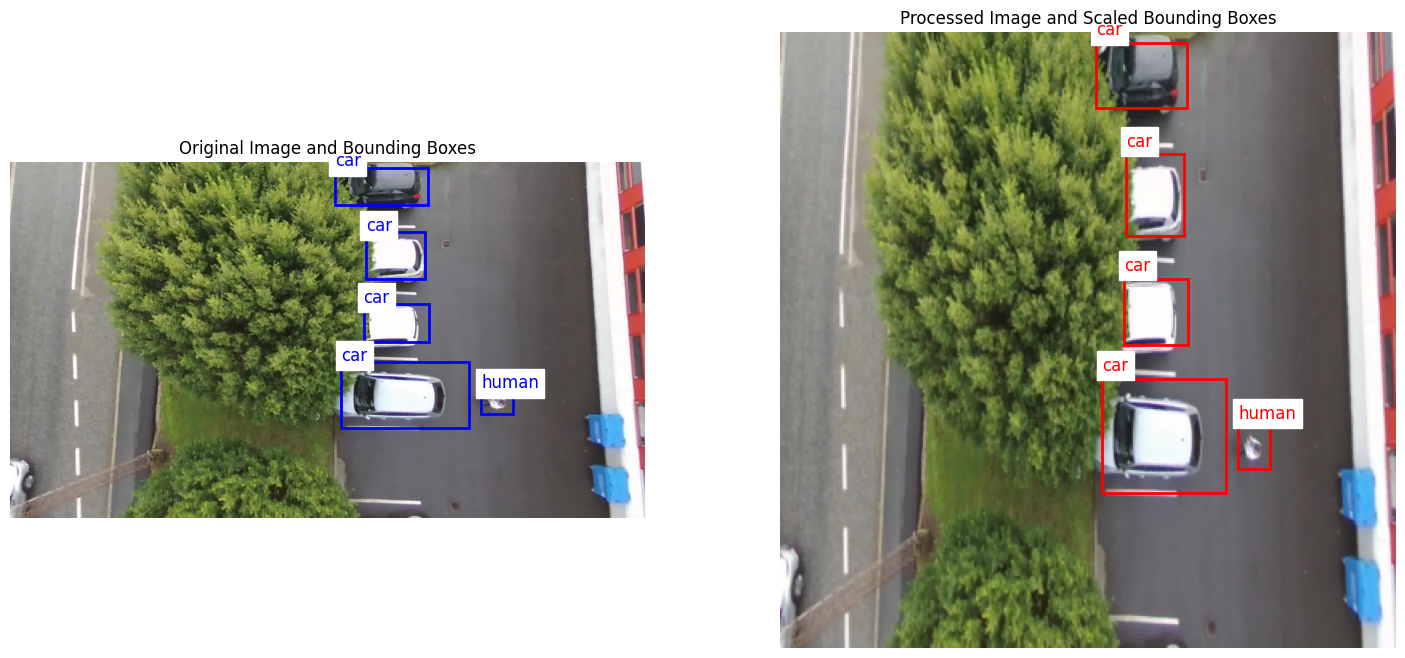

In [1]:
import os
import json
import random
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from transformers import AutoImageProcessor, AutoModelForObjectDetection

import wandb

# ---------------------------
# Device
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Hyperparameters
# ---------------------------
CONFIG = {
    "annotation_path": "auair2019/annotations_formatted_valid.json",
    "image_dir": "auair2019/images/",
    "train_split": 0.8,
    "val_split": 0.1,
    "test_split": 0.1,
    "batch_size": 16,
    "num_workers": 4,
    "num_epochs": 5,
    "accumulation_steps": 4,
    "base_lr": 1e-4,
    "weight_decay": 1e-4,
    "resize_size": {"height": 384, "width": 384},
    "model_name": "facebook/detr-resnet-50",
    "label_names": [
        'human', 'car', 'truck', 'van',
        'motorbike', 'bicycle', 'bus', 'trailer'
    ],
}

# ---------------------------
# Processor and Model Setup
# ---------------------------
processor = AutoImageProcessor.from_pretrained(
    CONFIG['model_name'],
    do_resize=True,
    size=CONFIG['resize_size'],
    do_rescale=True,
    do_normalize=True
)

id2label = {i: name for i, name in enumerate(CONFIG['label_names'])}
print(id2label)
label2id = {name: i for i, name in id2label.items()}
print(label2id)

model = AutoModelForObjectDetection.from_pretrained(
    CONFIG['model_name'],
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
model.to(device)
print(model.config.num_labels)
print(model.config.id2label)

# ---------------------------
# Dataset Definition
# ---------------------------
class AUAirDataset(Dataset):
    def __init__(self, annotation_path, image_dir, processor):
        if not os.path.isfile(annotation_path):
            raise FileNotFoundError(f"Annotation file not found: {annotation_path}")
        if not os.path.isdir(image_dir):
            raise NotADirectoryError(f"Image directory not found: {image_dir}")

        with open(annotation_path) as f:
            data = json.load(f)

        self.category_id_to_name = {cat["id"]: cat["name"] for cat in data.get("categories", [])}
        self.categories = {cat_id: idx for idx, cat_id in enumerate(self.category_id_to_name.keys())}
        self.idx_to_name = {v: self.category_id_to_name[k] for k, v in self.categories.items()}

        self.images = sorted(data.get("images", []), key=lambda x: x["id"])
        raw_annotations = data.get("annotations", [])

        self.processor = processor
        self.image_dir = image_dir

        valid_ids = {img["id"] for img in self.images}
        self.annotations = [ann for ann in raw_annotations if ann["image_id"] in valid_ids]
        self.image_id_to_annotations = {}
        for ann in self.annotations:
            self.image_id_to_annotations.setdefault(ann["image_id"], []).append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.image_dir, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")

        width, height = img_info["width"], img_info["height"]
        ann_list = self.image_id_to_annotations.get(img_info["id"], [])

        boxes, labels = [], []
        for ann in ann_list:
            x, y, w, h = ann["bbox"]
            x_min = max(0, x) / width
            y_min = max(0, y) / height
            x_max = min(x + w, width) / width
            y_max = min(y + h, height) / height
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(self.categories[ann["category_id"]])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "class_labels": labels, "image_id": torch.tensor([img_info["id"]])}

        pixel_values = self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)
        return pixel_values, target

# ---------------------------
# Data Splitting and Loaders
# ---------------------------
full_dataset = AUAirDataset(CONFIG['annotation_path'], CONFIG['image_dir'], processor)

dataset_size = len(full_dataset)
train_size = int(CONFIG['train_split'] * dataset_size)
val_size = int(CONFIG['val_split'] * dataset_size)
test_size = dataset_size - train_size - val_size

indices = list(range(dataset_size))
random.shuffle(indices)
train_idx = indices[:train_size]
val_idx = indices[train_size:train_size+val_size]
test_idx = indices[train_size+val_size:]

train_loader = DataLoader(full_dataset, batch_size=CONFIG['batch_size'], 
                          sampler=SubsetRandomSampler(train_idx), 
                          collate_fn=lambda b: tuple(zip(*b)), num_workers=CONFIG['num_workers'])
val_loader   = DataLoader(full_dataset, batch_size=CONFIG['batch_size'], 
                          sampler=SubsetRandomSampler(val_idx), 
                          collate_fn=lambda b: tuple(zip(*b)), num_workers=CONFIG['num_workers'])
test_loader  = DataLoader(full_dataset, batch_size=CONFIG['batch_size'], 
                          sampler=SubsetRandomSampler(test_idx), 
                          collate_fn=lambda b: tuple(zip(*b)), num_workers=CONFIG['num_workers'])

# ---------------------------
# Visualization
# ---------------------------

def denormalize_boxes(boxes, width, height):
    return boxes * torch.tensor([width, height, width, height])

def visualize_sample(dataset, index, processor):
    pixel_values, target = dataset[index]

    img_info = dataset.images[index]
    img_path = os.path.join(dataset.image_dir, img_info["file_name"])
    image = Image.open(img_path).convert("RGB")
    orig_width, orig_height = image.size

    boxes = target["boxes"]
    labels = target["class_labels"]

    fig, ax = plt.subplots(1, 2, figsize=(18, 8))

    ax[0].imshow(image)
    for box, label in zip(boxes.numpy(), labels.numpy()):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min * orig_width, y_min * orig_height), 
            (x_max - x_min) * orig_width, 
            (y_max - y_min) * orig_height,
            linewidth=2, edgecolor="blue", facecolor="none"
        )
        ax[0].add_patch(rect)
        label_name = dataset.idx_to_name[label]
        ax[0].text(x_min * orig_width, y_min * orig_height - 5, 
                  label_name, color="blue", fontsize=12, backgroundcolor="white")

    ax[0].set_title("Original Image and Bounding Boxes")
    ax[0].axis("off")

    processed = processor(images=image, return_tensors="pt")
    processed_img = processed["pixel_values"].squeeze()
    
    processed_img = processed_img.permute(1, 2, 0) 
    processed_img = processed_img.numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    processed_img = std * processed_img + mean
    processed_img = np.clip(processed_img, 0, 1)

    ax[1].imshow(processed_img)
    
    new_height, new_width = CONFIG['resize_size']['height'], CONFIG['resize_size']['width']
    for box, label in zip(boxes.numpy(), labels.numpy()):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min * new_width, y_min * new_height), 
            (x_max - x_min) * new_width, 
            (y_max - y_min) * new_height,
            linewidth=2, edgecolor="red", facecolor="none"
        )
        ax[1].add_patch(rect)
        label_name = dataset.idx_to_name[label]
        ax[1].text(x_min * new_width, y_min * new_height - 5, 
                  label_name, color="red", fontsize=12, backgroundcolor="white")

    ax[1].set_title("Processed Image and Scaled Bounding Boxes")
    ax[1].axis("off")

    plt.show()

visualize_sample(full_dataset, 50, processor)

In [ ]:
# ---------------------------
# Optimizer and Scheduler
# ---------------------------
optimizer = AdamW(model.parameters(), lr=CONFIG['base_lr'], weight_decay=CONFIG['weight_decay'])
scheduler = OneCycleLR(
    optimizer,
    max_lr=CONFIG['base_lr'],
    steps_per_epoch=len(train_loader),
    epochs=CONFIG['num_epochs']
)

scaler = GradScaler()

# ---------------------------
# WandB Initialization
# ---------------------------
current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
wandb.init(
    project="object-detection-fine-tuning",
    config={**CONFIG, **{"train_size": train_size, "val_size": val_size, "test_size": test_size}},
    name=f"run_{current_time}"
)
wandb.watch(model, log="all", log_freq=10)

# ---------------------------
# Training and Validation
# ---------------------------
def train_one_epoch(epoch):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad(set_to_none=True)

    for step, (images, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']} - Training", leave=False)):
        pixel_values = torch.stack(images).to(device, non_blocking=True)
        target_list = [{"boxes": t["boxes"].to(device), "class_labels": t["class_labels"].to(device)} for t in targets]

        with torch.amp.autocast(device_type=device.type):
            outputs = model(pixel_values=pixel_values, labels=target_list)
            loss = outputs.loss / CONFIG['accumulation_steps']

        scaler.scale(loss).backward()
        if (step + 1) % CONFIG['accumulation_steps'] == 0 or (step + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        total_loss += outputs.loss.item()
        wandb.log({"batch/train_loss": outputs.loss.item(), "step": epoch * len(train_loader) + step})

    return total_loss / len(train_loader)


def validate_one_epoch(epoch):
    model.eval()
    total_loss = 0.0
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=False)

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']} - Validation", leave=False):
            pixel_values = torch.stack(images).to(device)
            target_list = [{"boxes": t["boxes"].to(device), "class_labels": t["class_labels"].to(device)} for t in targets]

            outputs = model(pixel_values=pixel_values, labels=target_list)
            total_loss += outputs.loss.item()

            preds = []
            for b in range(len(images)):
                boxes = outputs.pred_boxes[b].cpu()
                scores, labels = outputs.logits[b].softmax(-1).cpu().max(-1)
                keep = labels != len(CONFIG['label_names'])
                preds.append({
                    "boxes": boxes[keep],
                    "scores": scores[keep],
                    "labels": labels[keep]
                })

            gts = [{"boxes": t['boxes'], "labels": t['class_labels']} for t in targets]
            metric.update(preds, gts)

    avg_loss = total_loss / len(val_loader)
    mAP = metric.compute()
    wandb.log({
    "epoch": epoch,
    "val_loss": avg_loss,
    **{
        f"mAP_{k}": (v.item() if v.numel() == 1 else v.tolist())
        for k, v in mAP.items() if isinstance(v, torch.Tensor)
    }
    })
    return avg_loss, mAP

# ---------------------------
# Run Training
# ---------------------------
checkpoint_dir = Path("checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

best_val_loss = float('inf')
epochs_no_improve = 0
for epoch in range(CONFIG['num_epochs']):
    train_loss = train_one_epoch(epoch)
    val_loss, val_mAP = validate_one_epoch(epoch)
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']} - "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, mAP: {val_mAP['map']:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save({
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'epoch': epoch
        }, checkpoint_dir / "best_checkpoint_512.pth")
        wandb.log({"best_val_loss": best_val_loss})
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= 3:
            print("Early stopping triggered.")
            break

print("Training complete.")

# ---------------------------
# Evaluation
# ---------------------------
def denormalize_boxes(boxes, width, height):
    boxes = boxes.clone()
    boxes[:, 0] *= width
    boxes[:, 1] *= height
    boxes[:, 2] *= width
    boxes[:, 3] *= height
    return boxes

def evaluate(model, data_loader):
    model.eval()
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    all_preds = []
    all_gts = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating", leave=False):
            pixel_values = torch.stack(images).to(device)
            outputs = model(pixel_values=pixel_values)

            for i in range(len(images)):
                image = images[i]
                height, width = image.shape[1:]

                boxes = outputs.pred_boxes[i].cpu()
                boxes = denormalize_boxes(boxes, width, height)

                scores, labels = outputs.logits[i].softmax(-1).cpu().max(-1)
                keep = labels != len(CONFIG['label_names'])
                pred = {
                    "boxes": boxes[keep],
                    "scores": scores[keep],
                    "labels": labels[keep]
                }

                gt_boxes = denormalize_boxes(targets[i]['boxes'].clone(), width, height)
                gt = {
                    "boxes": gt_boxes,
                    "labels": targets[i]['class_labels']
                }

                all_preds.append(pred)
                all_gts.append(gt)

    metric.update(all_preds, all_gts)
    metrics = metric.compute()

    print("\nOverall mAP: {:.4f}".format(metrics["map"]))

    if "map_50" in metrics:
        print("mAP at IoU=0.5: {:.4f}".format(metrics["map_50"]))

    if "map_75" in metrics:
        print("mAP at IoU=0.75: {:.4f}".format(metrics["map_75"]))

    print("\nClass-wise mAP:")
    for label_name, score in zip(CONFIG['label_names'], metrics['map_per_class']):
        print(f"{label_name}: {score:.4f}")

    wandb.log({
        f"eval/{k}": (v.item() if v.numel() == 1 else v.tolist())
        for k, v in metrics.items() if isinstance(v, torch.Tensor)
    })

    return metrics

results = evaluate(model, test_loader)